# Step 1: Gather data, determine the method of data collection and provenance of the data

For this project, I selected a dataset from Kaggle here: https://www.kaggle.com/datasets/johnhallman/complete-poetryfoundationorg-dataset/data

The dataset contains most poems available on poetryfoundation.org.

# Step 2: Identify a Deep Learning Problem
This project aims to develop a deep learning model for generating poetry based on a given starting phrase.

Approach:
* Model Architecture: Employ a recurrent neural network (RNN) which can write poetry.
* Evaluation Strategy: Evaluate the model's performance accuracy score as well as human evaluation of looking at the text generated.

In [1]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

2024-04-30 08:07:23.595123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 08:07:23.595191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 08:07:23.596787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data 

In [2]:
poems_df = pd.read_csv('/kaggle/input/complete-poetryfoundationorg-dataset/kaggle_poem_dataset.csv', index_col=0)
poems_df.head()

,Author,Title,Poetry Foundation ID,Content
0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."
2,Jody Gladding,1-800-FEAR,57135,We'd like to talk with you about fear t...
3,Joseph Brodsky,1 January 1965,56736,The Wise Men will unlearn your name.\nAbove yo...
4,Ted Berrigan,3 Pages,51624,For Jack Collom\n10 Things I do Every Day\n\np...


In [3]:
poems_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15652 entries, 0 to 15651
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Author                15652 non-null  object
 1   Title                 15651 non-null  object
 2   Poetry Foundation ID  15652 non-null  int64 
 3   Content               15652 non-null  object
dtypes: int64(1), object(3)
memory usage: 611.4+ KB


The poem dataset has 15652 entries, with only 1 null in the Title column. Here is a breakdown of all the features:
* Author: The author of the poem in "object" type
* Title: The title of the poem in "object type
* Poetry Foundation ID: This corresponds to the ID which can be used to find the same poem on the poetryfoundation website. This is an int type as it's numerical
* Content: This is the main poem - the main content and is in "object" type

Next, let's explore the data.

In [4]:
# look at null values
poems_df[poems_df.isnull().any(axis=1)]

,Author,Title,Poetry Foundation ID,Content
9234,Hayden Carruth,NaN,42606,You died. And because you were Greek they gave...


A simple google search reveals that the "Title" of the poem above (by Hayden Carruth) is called "None" so I will be adding that value in it's Title.

In [5]:
# Fill NAN value with the title = None
poems_df["Title"].fillna("None", inplace=True)

/tmp/ipykernel_7967/624624624.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  poems_df["Title"].fillna("None", inplace=True)


In [6]:
poems_df.iloc[9234]

Author                                                     Hayden Carruth
Title                                                                None
Poetry Foundation ID                                                42606
Content                 You died. And because you were Greek they gave...
Name: 9234, dtype: object

In [7]:
poems_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15652 entries, 0 to 15651
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Author                15652 non-null  object
 1   Title                 15652 non-null  object
 2   Poetry Foundation ID  15652 non-null  int64 
 3   Content               15652 non-null  object
dtypes: int64(1), object(3)
memory usage: 611.4+ KB


All null values have been eliminated.

In [8]:
poems_df['Author'].value_counts().head()

Author
William Shakespeare      85
Anonymous                82
Alfred, Lord Tennyson    78
Rae Armantrout           62
William Wordsworth       59
Name: count, dtype: int64

William Shakespeare is the most frequent author but let's try another one:

In [9]:
filtered_poems = poems_df[poems_df['Author'] == "Alfred, Lord Tennyson"]
filtered_poems.head()

,Author,Title,Poetry Foundation ID,Content
1730,"Alfred, Lord Tennyson","Break, Break, Break",45318,"Break, break, break,\nOn thy cold gray stones,..."
2134,"Alfred, Lord Tennyson",The Charge of the Light Brigade,45319,"I\n\nHalf a league, half a league,\nHalf a lea..."
2315,"Alfred, Lord Tennyson",Claribel,45320,Where Claribel low-lieth\nThe breezes pause an...
2687,"Alfred, Lord Tennyson",Crossing the Bar\n \n \n \n Launch Audio in...,45321,"Sunset and evening star,\nAnd one clear call f..."
3529,"Alfred, Lord Tennyson",The Eagle,45322,He clasps the crag with crooked hands;\nClose ...


Let's now visualize the top 20 authors by number of Poems.

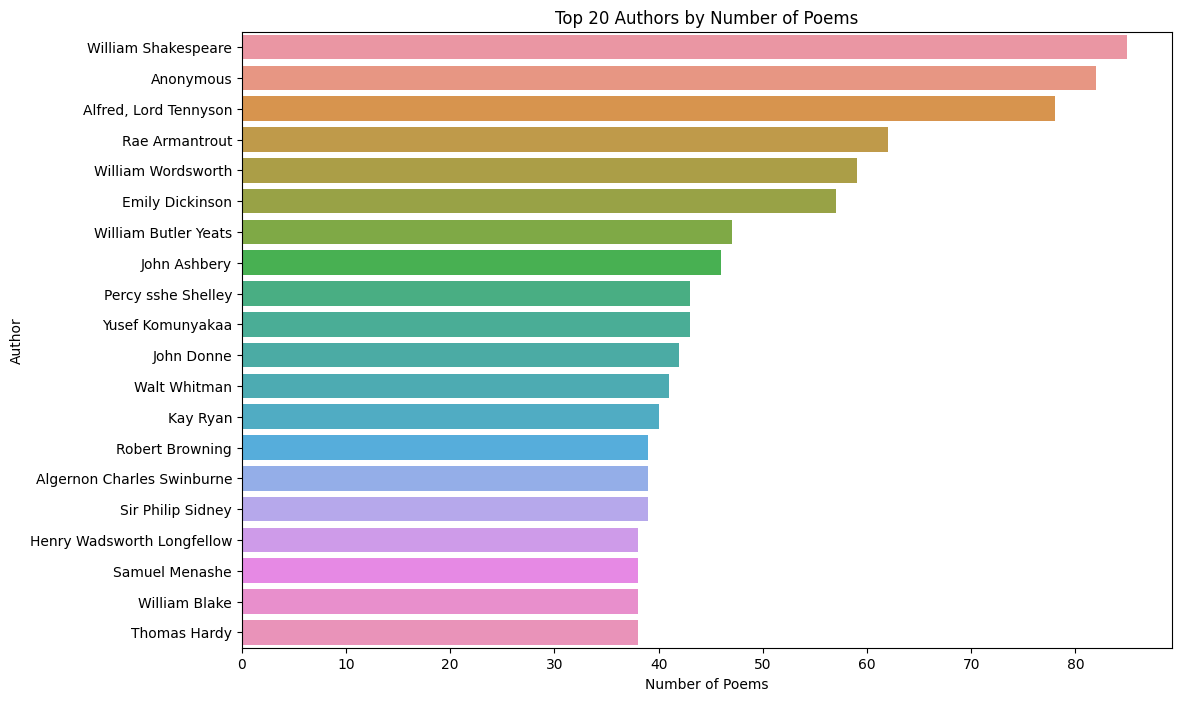

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.countplot(y='Author', data=poems_df, order=poems_df['Author'].value_counts().index[:20])
plt.title('Top 20 Authors by Number of Poems')
plt.xlabel('Number of Poems')
plt.ylabel('Author')
plt.show()

The poems contain special characters so let's replace all non-alpha-numeric characters by a white space:

In [11]:
# remove non-alpha numeric characters with white space
filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ").str.replace("\n", " ").str.replace("\n", " ").str.replace("?", " ").str.replace("{", " ").str.replace("}", " ") \
             .str.replace("(", " ").str.replace(")", " ").str.replace("!", " ").str.replace("-", " ") \
             .str.replace(":", " ").str.replace(";", " ").str.replace(".", " ").str.replace("—", " ").str.replace(",", " ").str.replace("ë", " ") \
             .str.replace("ä", " ").str.replace("ë", " ").str.replace("é", " ").str.replace("ï", " ").str.replace("ö", " ").str.replace("è", " ").str.replace("æ", " ").str.replace("'", " ").str.replace("\"", " ").str.replace("’", " ").str.replace("“", " ").str.replace("”", " ")

# convert to lowercase
filtered_poems["Content"] = filtered_poems["Content"].str.lower()


/tmp/ipykernel_7967/3183964519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ").str.replace("\n", " ").str.replace("\n", " ").str.replace("?", " ").str.replace("{", " ").str.replace("}", " ") \
/tmp/ipykernel_7967/3183964519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_poems["Content"] = filtered_poems["Content"].str.lower()


The next step is to build a tokenizer by breaking each poem into a sequence of characters and then indexing the caracters by numbers.

In [12]:
tokenizer = Tokenizer(char_level = True, lower = True)
tokenizer.fit_on_texts(filtered_poems['Content'])

In [13]:
char_to_num = tokenizer.word_index
num_to_char = tokenizer.index_word

all_chars = list(char_to_num.keys())

# view characters and the indices
char_to_num

{' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'o': 5,
 'h': 6,
 'n': 7,
 'r': 8,
 'i': 9,
 's': 10,
 'l': 11,
 'd': 12,
 'w': 13,
 'm': 14,
 'u': 15,
 'f': 16,
 'g': 17,
 'y': 18,
 'c': 19,
 'b': 20,
 'p': 21,
 'k': 22,
 'v': 23,
 'q': 24,
 'z': 25,
 'x': 26,
 'j': 27,
 'æ': 28}

Let's look at a histogram of total counts of each character (top 10)

In [14]:
character_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["character", "count"])
character_frequency = character_frequency.sort_values("count", ascending=False)

<Figure size 1200x1000 with 0 Axes>

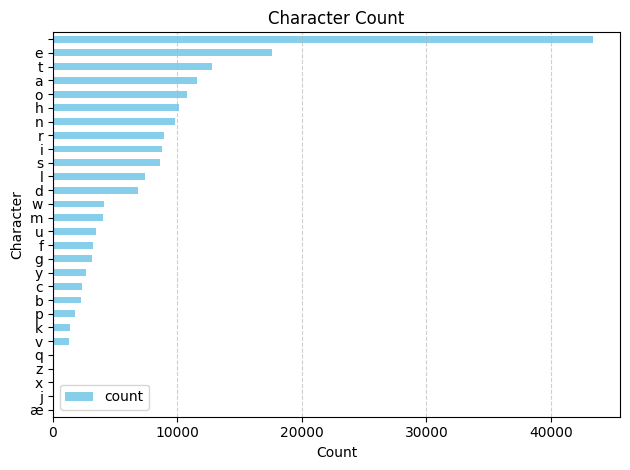

In [15]:
# Create a horizontal bar chart
plt.figure(figsize=(12, 10))
character_frequency.set_index("character").plot(kind="barh", color='skyblue', title="Character Count")
plt.xlabel("Count")
plt.ylabel("Character")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Let's transform the text to a sequence of indices.

In [16]:
dataset = tokenizer.texts_to_sequences(filtered_poems["Content"])

In [17]:
# let's print the first poem in the dataset
print(dataset[0])

[20, 8, 2, 4, 22, 1, 1, 20, 8, 2, 4, 22, 1, 1, 20, 8, 2, 4, 22, 1, 1, 5, 7, 1, 3, 6, 18, 1, 19, 5, 11, 12, 1, 17, 8, 4, 18, 1, 10, 3, 5, 7, 2, 10, 1, 1, 5, 1, 10, 2, 4, 1, 1, 4, 7, 12, 1, 9, 1, 13, 5, 15, 11, 12, 1, 3, 6, 4, 3, 1, 14, 18, 1, 3, 5, 7, 17, 15, 2, 1, 19, 5, 15, 11, 12, 1, 15, 3, 3, 2, 8, 1, 3, 6, 2, 1, 3, 6, 5, 15, 17, 6, 3, 10, 1, 3, 6, 4, 3, 1, 4, 8, 9, 10, 2, 1, 9, 7, 1, 14, 2, 1, 1, 1, 5, 1, 1, 13, 2, 11, 11, 1, 16, 5, 8, 1, 3, 6, 2, 1, 16, 9, 10, 6, 2, 8, 14, 4, 7, 1, 10, 1, 20, 5, 18, 1, 1, 3, 6, 4, 3, 1, 6, 2, 1, 10, 6, 5, 15, 3, 10, 1, 13, 9, 3, 6, 1, 6, 9, 10, 1, 10, 9, 10, 3, 2, 8, 1, 4, 3, 1, 21, 11, 4, 18, 1, 1, 5, 1, 1, 13, 2, 11, 11, 1, 16, 5, 8, 1, 3, 6, 2, 1, 10, 4, 9, 11, 5, 8, 1, 11, 4, 12, 1, 1, 3, 6, 4, 3, 1, 6, 2, 1, 10, 9, 7, 17, 10, 1, 9, 7, 1, 6, 9, 10, 1, 20, 5, 4, 3, 1, 5, 7, 1, 3, 6, 2, 1, 20, 4, 18, 1, 1, 1, 4, 7, 12, 1, 3, 6, 2, 1, 10, 3, 4, 3, 2, 11, 18, 1, 10, 6, 9, 21, 10, 1, 17, 5, 1, 5, 7, 1, 3, 5, 1, 3, 6, 2, 9, 8, 1, 6, 4, 23, 2, 7, 1, 

We want to transform this into a dataset  𝑋  and  𝑦 , where each data point x is a window of consecutive characters and y is the next character immediately after the window.

Ex: 
* x0: You died. And
* x1: b
* x2: ecause you we


so on ..

In [18]:
# sliding window
SEQUENCE_LENGTH = 10

X = []
y = []

for poem in dataset:
    for window_start_idx in range(len(poem) - SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(poem[window_start_idx: window_end_idx])
        y.append(poem[window_end_idx])

X = np.array(X)
y = np.array(y)

# shapes
print(X.shape)
print(y.shape)

(185712, 10)
(185712,)


In [19]:
#  inspect x&y
for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("*******")

X: [20  8  2  4 22  1  1 20  8  2]
y: 4
*******
X: [ 8  2  4 22  1  1 20  8  2  4]
y: 22
*******
X: [ 2  4 22  1  1 20  8  2  4 22]
y: 1
*******
X: [ 4 22  1  1 20  8  2  4 22  1]
y: 1
*******
X: [22  1  1 20  8  2  4 22  1  1]
y: 20
*******


In [20]:
#  back-transform indices to letters
for i in range(5):
    print("X:", [num_to_char[num] for num in X[i]])
    print("y:", num_to_char[y[i]])
    print("*******")

X: ['b', 'r', 'e', 'a', 'k', ' ', ' ', 'b', 'r', 'e']
y: a
*******
X: ['r', 'e', 'a', 'k', ' ', ' ', 'b', 'r', 'e', 'a']
y: k
*******
X: ['e', 'a', 'k', ' ', ' ', 'b', 'r', 'e', 'a', 'k']
y:  
*******
X: ['a', 'k', ' ', ' ', 'b', 'r', 'e', 'a', 'k', ' ']
y:  
*******
X: ['k', ' ', ' ', 'b', 'r', 'e', 'a', 'k', ' ', ' ']
y: b
*******


## Train and Validation

In this section, the data will be split into train and validation sets.

In [21]:
from sklearn.model_selection import train_test_split

# split train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1)

print(X_train.shape, y_train.shape)      
print(X_validation.shape, y_validation.shape)

(167140, 10) (167140,)
(18572, 10) (18572,)


**Embedding Layers**

In order to feed the data into the model, it needs embedding layers in order to provide a meaningful numerical representation for categorial data.

In [22]:
number_of_classes = len(all_chars) + 1
embedding_dim = 8

# initilize embedding layer
embedding_layer = Embedding(number_of_classes, embedding_dim) 

In [23]:
one_window = X[0] # shape: (10) 

embedding_layer(one_window).numpy() # shape: (10, embedding_dim)

array([[ 0.00436282, -0.04671041, -0.00168318,  0.02596167, -0.04465821,
        -0.0235558 ,  0.02467478, -0.04430902],
       [ 0.00309316,  0.02767308,  0.02239834, -0.020547  ,  0.0103529 ,
        -0.00802509, -0.02314291, -0.03212003],
       [-0.04999682,  0.03930069, -0.00817873, -0.00081998,  0.03010304,
         0.02254529, -0.0210497 ,  0.0412868 ],
       [ 0.02230151, -0.03285692,  0.02647581, -0.0426586 , -0.00865278,
        -0.01261331, -0.00275872, -0.0359084 ],
       [ 0.04627745, -0.0295337 ,  0.02588082,  0.00210106, -0.03221562,
         0.00563075, -0.01454283, -0.04173608],
       [ 0.00428706,  0.01028978, -0.02798965,  0.01701125, -0.03042558,
        -0.02064004, -0.03356835, -0.00263887],
       [ 0.00428706,  0.01028978, -0.02798965,  0.01701125, -0.03042558,
        -0.02064004, -0.03356835, -0.00263887],
       [ 0.00436282, -0.04671041, -0.00168318,  0.02596167, -0.04465821,
        -0.0235558 ,  0.02467478, -0.04430902],
       [ 0.00309316,  0.02767308

Apply PCA to reduce dimensions to 2D.

In [24]:
from sklearn.decomposition import PCA

all_embeddings = embedding_layer(np.arange(number_of_classes))
pca = PCA(n_components = 2)
all_embeddings_2d = pca.fit_transform(all_embeddings)

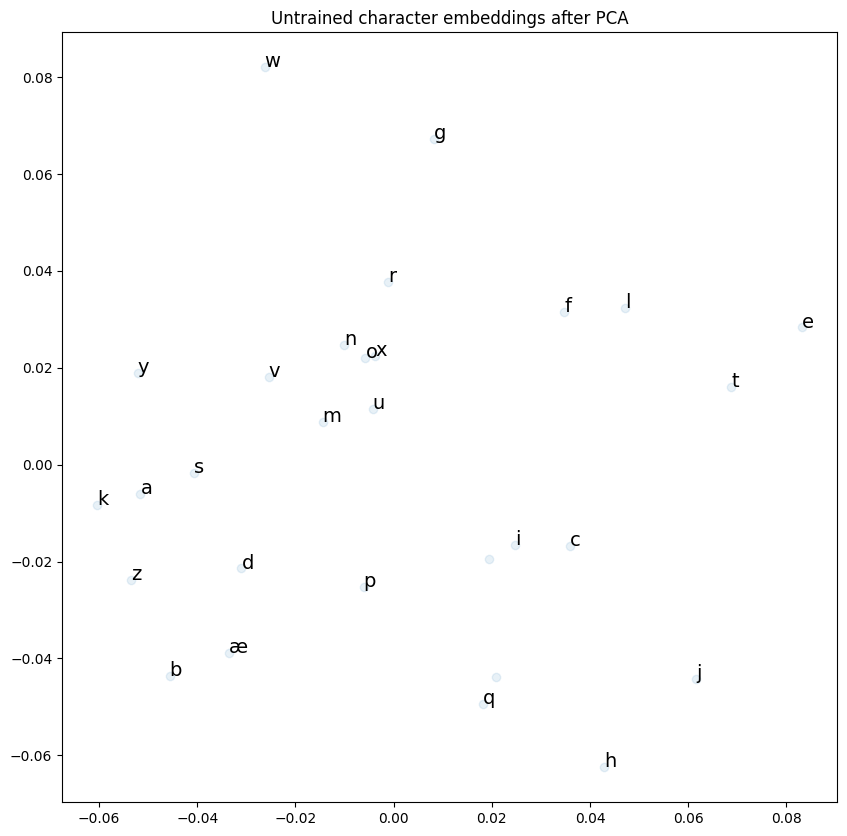

In [25]:
# VIEW PCA

plt.figure(figsize=(10, 10))
# plot the PCA components
plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], alpha=0.1)
# add characters to the plot
for num, char in num_to_char.items():
    plt.text(all_embeddings_2d[num, 0], all_embeddings_2d[num, 1], char, fontsize=14)

plt.title("Untrained character embeddings after PCA")
plt.show()

In the plot above, the untrained embeddings look random which was expected.

## Model

The first model will be a **single layer RNN**. It will try to predict the next character based on the input. The final layer should return probabilities over possible characters. LSTM, dense, and batch normalization layers should help with learning process.

In [26]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences = False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [27]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [28]:
# Display summary
RNN_charlevel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=20,
        validation_data=(X_validation, y_validation))

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.2736 - loss: 2.7620 - val_accuracy: 0.2274 - val_loss: 2.9130
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.3946 - loss: 2.0754 - val_accuracy: 0.2274 - val_loss: 2.7603
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.4175 - loss: 1.9530 - val_accuracy: 0.2615 - val_loss: 2.5682
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4340 - loss: 1.8875 - val_accuracy: 0.3595 - val_loss: 2.1408
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.4454 - loss: 1.8469 - val_accuracy: 0.4085 - val_loss: 1.9646
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.4502 - loss: 1.8183 - val_accuracy: 0.4343 - val_loss: 1.8894
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.4611 - loss: 1.7838 - val_accuracy: 0.4272 - val_loss: 1.8989
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.4676 - loss: 1.7591 - 

Next, let's look at the accuracy of training and validation.

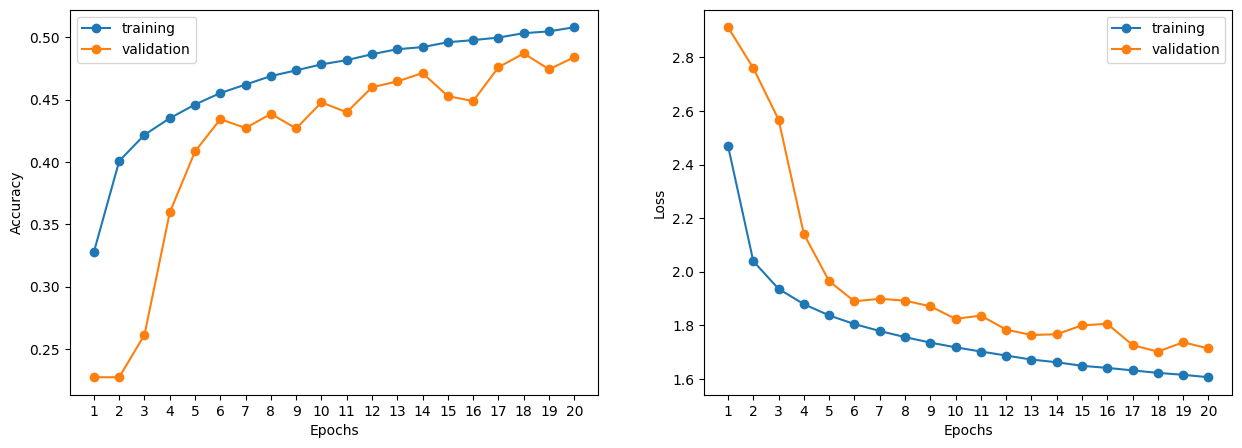

In [30]:
epochs = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

The accuracy only goes up to about 50% but let's also look at text generation to see if it makes sense. The accuracy and loss plots show the weakness of this model but these metrics should not be the only way to determine text generation as it requires human understanding also.

In [31]:
input_phrase = ["When to the session of sweet silent"]

# process for the model
processed_phrase = tokenizer.texts_to_sequences(input_phrase)[0]

for i in range(200):
    # extract last 10 characters
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype = np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH))

    # RNN gives probability of each character as the next one
    predict_proba = RNN_charlevel.predict(network_input)[0]
    
    # sample characters using these chances
    predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

    # add new index at the end of list
    processed_phrase.append(predicted_index)
    
# map indices to characters and join into single string
output_phrase = "".join([num_to_char.get(number, "") for number in processed_phrase])    

print(output_phrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

Overall, the model is trying to produce words that resemble the English language but it is struggling.

In [32]:
RNN_charlevel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 10, 8)          │           232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,089 (949.57 KB)

 Trainable params: 80,901 (316.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 161,804 (632.05 KB)

#### Improving the model

Let's repeat the process by feeling it text word-by-word. This should hopefully improve the output.

In [33]:
tokenizer = Tokenizer(char_level = False, lower = True) 
tokenizer.fit_on_texts(filtered_poems['Content'])

In [34]:
word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Vocabulary size: {len(all_words)}")

Vocabulary size: 4854


In [35]:
dataset = tokenizer.texts_to_sequences(filtered_poems["Content"])

In [36]:
# First poem in the dataset displayed using word numbers
print(dataset[0])

[488, 488, 488, 20, 27, 232, 375, 1291, 28, 151, 2, 8, 103, 9, 11, 1047, 271, 864, 1, 758, 9, 664, 6, 17, 28, 140, 14, 1, 2576, 29, 537, 9, 22, 1292, 10, 19, 2577, 36, 665, 28, 140, 14, 1, 2578, 759, 9, 22, 865, 6, 19, 538, 20, 1, 1722, 2, 1, 666, 1293, 152, 20, 4, 62, 1723, 318, 1, 866, 13, 28, 14, 1, 254, 3, 5, 867, 7, 141, 2, 1, 342, 3, 5, 144, 9, 12, 186, 488, 488, 488, 36, 1, 539, 3, 27, 1724, 28, 151, 13, 1, 540, 541, 3, 5, 63, 9, 12, 93, 56, 159, 113, 233, 4, 17]


In [37]:
SEQUENCE_LENGTH = 5

X = []
y = []

for poem in dataset:
    for window_start_idx in range(len(poem)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(poem[window_start_idx: window_end_idx])
        y.append(poem[window_end_idx])

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(35555, 5)
(35555,)


In [38]:
for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("*******")

X: [488 488 488  20  27]
y: 232
*******
X: [488 488  20  27 232]
y: 375
*******
X: [488  20  27 232 375]
y: 1291
*******
X: [  20   27  232  375 1291]
y: 28
*******
X: [  27  232  375 1291   28]
y: 151
*******


In [39]:
for i in range(5):
    print("X:", [number_to_word[num] for num in X[i]])
    print("y:", number_to_word[y[i]])
    print("*******")

X: ['break', 'break', 'break', 'on', 'thy']
y: cold
*******
X: ['break', 'break', 'on', 'thy', 'cold']
y: gray
*******
X: ['break', 'on', 'thy', 'cold', 'gray']
y: stones
*******
X: ['on', 'thy', 'cold', 'gray', 'stones']
y: o
*******
X: ['thy', 'cold', 'gray', 'stones', 'o']
y: sea
*******


In [40]:
# split train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1)

In [41]:
print(X_train.shape, y_train.shape)      
print(X_validation.shape, y_validation.shape)

(31999, 5) (31999,)
(3556, 5) (3556,)


### Deep Recurrent neural networks

Let's now use a deep recurrent neural network this time. With more layers, the model can learn more relationships.
* first layer returns the output for all steps and second last passes final output.

In [42]:
number_of_classes = len(all_words) + 1

RNN_wordlevel = Sequential()
RNN_wordlevel.add(Embedding(input_dim=number_of_classes, output_dim=8))

RNN_wordlevel.add(GRU(64, activation='relu', return_sequences=True))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.2))

RNN_wordlevel.add(GRU(32, activation='relu', return_sequences=False))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.2))

RNN_wordlevel.add(Dense(16, activation='relu'))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.2))

RNN_wordlevel.add(Dense(number_of_classes, activation='softmax'))

In [43]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate = 0.001),
    metrics=['accuracy']
)

In [44]:
RNN_wordlevel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=25,
        validation_data=(X_validation, y_validation))

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 9.7233e-04 - loss: 8.4802 - val_accuracy: 0.0014 - val_loss: 8.4545
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.0167 - loss: 8.4156 - val_accuracy: 0.0397 - val_loss: 8.4087
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.0501 - loss: 8.3107 - val_accuracy: 0.0726 - val_loss: 8.3278
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.0696 - loss: 8.1427 - val_accuracy: 0.0731 - val_loss: 8.2070
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.0749 - loss: 7.8850 - val_accuracy: 0.0726 - val_loss: 8.0447
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.0774 - loss: 7.5568 - val_accuracy: 0.0728 - val_loss: 7.8191
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.0815 - loss: 7.2068 - val_accuracy: 0.0726 - val_loss: 7.4681
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0877 - loss: 6.8664 - val_accuracy: 0.0

In [46]:
RNN_wordlevel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 5, 8)           │        38,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 5, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4855)           │        82,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,455 (1.67 MB)

 Trainable params: 145,743 (569.31 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 291,488 (1.11 MB)

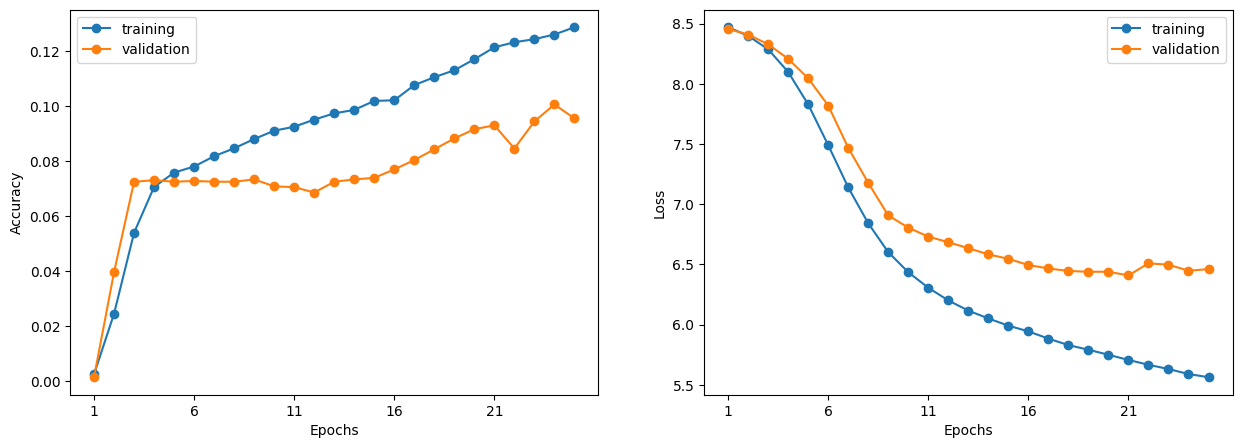

In [47]:
epochs = range(1, 26)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Loss")
plt.legend()
plt.show()

The accuracy seems low compared to the previous model but let's also generate text to see it makes a difference.

In [48]:
input_phrase = "Muse will you narrate the doings of her who has plenty of gold"

# process for the model
processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]

for i in range(50):
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH))
    predict_proba = RNN_wordlevel.predict(network_input)[0]
    predicted_index = np.random.choice(number_of_classes, 1, p = predict_proba)[0]
    processed_phrase.append(predicted_index)
    
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

Compared to the previous model, this is an improvement as there are a lot more words in proper english. It still has a long way to go as the poem does not make sense. 

Let's try generating another poem.

In [49]:
input_phrase = "it is a lovely day"

processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]

for i in range(50):
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH))
    predict_proba = RNN_wordlevel.predict(network_input)[0]
    predicted_index = np.random.choice(number_of_classes, 1, p = predict_proba)[0]
    processed_phrase.append(predicted_index)
    
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

# Conclusion

This project was an experiment with recurrent neural network (RNN) models for generating poetry. The initial single-layer RNN struggled to produce English-language poetry but it was a good starting point to see if a poem can be generated. The second deep neural network model performed better as it used more English words but still faced challenges in generating meaningful poems. This highlights the complexities of natural language generation tasks, especially in creative contexts like poetry. Overall, there is lots of room for improvement and it is possible to refine the model architecture further to improve the quality and coherence of generated text.